# Introduction

In [ ]:
!pip install torchdata
!pip install portalocker>=2.0.0

In [ ]:
import string
import random
from collections import defaultdict

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

import torch
import torchdata
import torchtext
torchtext.disable_torchtext_deprecation_warning()
from torchtext.datasets import IMDB

import nltk
from nltk.util import ngrams as build_ngrams
from nltk.tokenize import word_tokenize

import spacy

from tqdm import tqdm

# Data

We'll use the IMDB movies review dataset

In [ ]:
train_data, test_data = IMDB(split=('train', 'test'))

train_data = list(tqdm(train_data, total=25000))
test_data = list(tqdm(test_data, total=25000))

In [ ]:
y_train, X_train = zip(*train_data)
y_test, X_test = zip(*test_data)
print(len(X_train))
print(len(X_test))

In [ ]:
for id in range(3):
    print(X_train[id])
    print()

# Recap: SVM Classifier

We first recap how to make a text sentiment classifier.

## Training the model

We will use SVC (support vector classifier) for training. The labels are:

```
1 - Negative
2 - Positive
```
We will use TF-IDF to convert our text to numerical form.

**TF-IDF (Term Frequency - Inverse Document Frequence)**

TF-IDF statistical measure that evaluates how relevant a word is to a document in a collection of documents. TF-IDF is computed as follows:

$$ \text{tf-idf}(t, d, D) = \text{tf}(t,d) * \text{idf}(t,D) $$

*Term Frequency:* $\text{tf}(t,d)$

The simplest choice is to use the frequency of a term (word) in a document.

*Inverse Document Frequency:* $\text{idf}(t,D)$

It measures how much information the word provides, i.e., if it's common or rare across all documents. It is the **logarthmic scaled** of inverse fraction of the document that contain word. Definition is as per [Wiki](https://en.wikipedia.org/wiki/Tf%E2%80%93idf).

TF-IDF identifies which words are auto occuring (stop words) and assigns them a very low or zero value so we don't need to manually remove them.

Lastly, the Sklearn API accepts strings and we don't have to tokenize the text ourselves.

In [ ]:
# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [ ]:
# Train the SVM classifier
clf = SVC(kernel='linear')
_ = clf.fit(X_train, y_train)  # SVC takes some time to train

In [ ]:
# Make predictions on the test data
y_pred = clf.predict(X_test)

In [ ]:
# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [ ]:
sentences = ["I was bored during this movie", "The movie was fun"]
sentence_vectors = vectorizer.transform(sentences)
clf.predict(sentence_vectors)  # 1 is neg. 2 is pos

# Tokenization

Now we'll take a look at how we can process text to be fed to models. Specifically, we'll take a look at:

1. Removing stop words from the text
2. Tokenizing the text
3. Converting the text to numerical form to be used by models

## Custom text processing functions

First, we will take a look at how we can manually write functions for tokenization, etc.

In the comments, you'll also find some of the limitations of the function (which are intentionally not taken care of for now)

In [ ]:
# Define a function to remove punctuation.
# This is often needed because when tokenizing, punctuation can be a problem
# for example, we want only one token for the word "close" but if "close," and "close." also exist in text corpus
# we will have 3 tokens just representing the word close ("close"|"close,"|"close.")
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

In [ ]:
# Define a function to remove stop words
def remove_stopwords(text):

    # The list could be ever expanding. Not to mention, if we dont remove punctuation beforehand, this function will not work properly.
    # This is also made to only work with lower case words so we need to lower our text.
    stopwords = set([
        "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself",
        "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself",
        "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these",
        "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do",
        "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while",
        "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before",
        "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again",
        "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each",
        "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than",
        "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"
    ])

    return ' '.join(word for word in text.split() if word.lower() not in stopwords)

In [ ]:
# Tokenize the text. For now we will just use split over white space.
def tokenize(text):
    return text.split()

To save time, we will use a small part of the dataset

In [ ]:
n_samples = 100
data = []

for record in tqdm(train_data, total=n_samples):

    data.append(record[1])  # [0] is the sentiment label. we dont need that.

    if len(data) >= n_samples:
        break

In [ ]:
# Create vocabulary from training data
vocab = set()
for text in tqdm(data, desc='Creating Vocab'):
    text = text.lower()
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    tokens = tokenize(text)
    vocab.update(tokens)

In [ ]:
# Create word to index mapping. This will be used to convert words to numerical form so it can be fed to models
# each word will be converted to the integer value stored against it in the dict, which comes from it's index hence word_to_idx
word_to_idx = {word: idx for idx, word in tqdm(enumerate(vocab), desc='Building Word 2 Idx')}

In [ ]:
# Print the first few words and their indices
print("Word to Index Mapping:")
for word in list(vocab)[:10]:
    print(f"{word}: {word_to_idx[word]}")

In [ ]:
# Lets take a look at an example
test_idx = 10

text = data[test_idx]

processed_text = remove_punctuation(text.lower())
processed_text = remove_stopwords(processed_text)
tokens = tokenize(processed_text)

idxs = [word_to_idx[token] for token in tokens]

print('Original Text:')
print(text)
print('-'*30)
print('Tokens:')
print(tokens)
print('-'*30)
print('Numerical form (Idxs)')
print(idxs)

## Using Spacy

As we saw, doing this manually has quite a few limitations.

One that hasn't been mentioned above is that we did a very basic implementation for English, but if we want to work with multiple languages, we need to make these functionalities for them as well, which can be challenging if the developer has limited understanding of the other language.

We CAN work around them but that adds a lot of needless development overhead. Which is why it's better to use a library to take care of things like this.

The 2 most popular libraries are Spacy and NLTK. Here we will use Spacy.

In [ ]:
# We need to download the english data and tokenizer for spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
# Define a function to remove stop words using spaCy
def remove_stopwords_sp(text):  # _sp to keep it seperate from our own implementation.
    doc = nlp(text)
    return ' '.join(token.text for token in doc if not token.is_stop)

In [ ]:
# Tokenize the text using spaCy
def tokenize_sp(text):
    doc = nlp(text)
    return [token.text for token in doc]

In [ ]:
# Create vocabulary from training data
vocab = set()
for text in tqdm(data, desc='Creating Vocab'):
    text = remove_stopwords_sp(text.lower())  # .lower to maintain similarity with our custom implementation
    tokens = tokenize_sp(text)
    vocab.update(tokens)

In [ ]:
# Create word to index mapping
word_to_idx = {word: idx for idx, word in tqdm(enumerate(vocab), desc='Building Word 2 Idx')}

In [ ]:
# Print the first few words and their indices
print("Word to Index Mapping:")
for word in list(vocab)[:10]:
    print(f"{word}: {word_to_idx[word]}")

In [ ]:
# Lets take a look at an example
test_idx = 10

text = data[test_idx]

processed_text = remove_stopwords_sp(text.lower())
tokens = tokenize_sp(processed_text)

idxs = [word_to_idx[token] for token in tokens]

print('Original Text:')
print(text)
print('-'*30)
print('Tokens:')
print(tokens)
print('-'*30)
print('Numerical form (Idxs)')
print(idxs)

**Something to notice:** As seen from the examples below, we don't have to remove punctuation. Spacy makes a seperate token for punctuation marks. This lets our data contain punctuation and, in theory, should be able to give our model understanding of these punctuation marks.

In [ ]:
tokenize("Hi, I Love Machine Learning and I want to be a pro at it.")

In [ ]:
tokenize_sp("Hi, I Love Machine Learning and I want to be a pro at it.")  # different tokens for punctuation marks

# N-Gram Language Model

Now we will build an N-gram language model.

How can we compute probabilities of entire sequences of words like $P(w_1,w_2,...,w_n)$? One thing we can do is decompose this probability using the chain rule of probability:

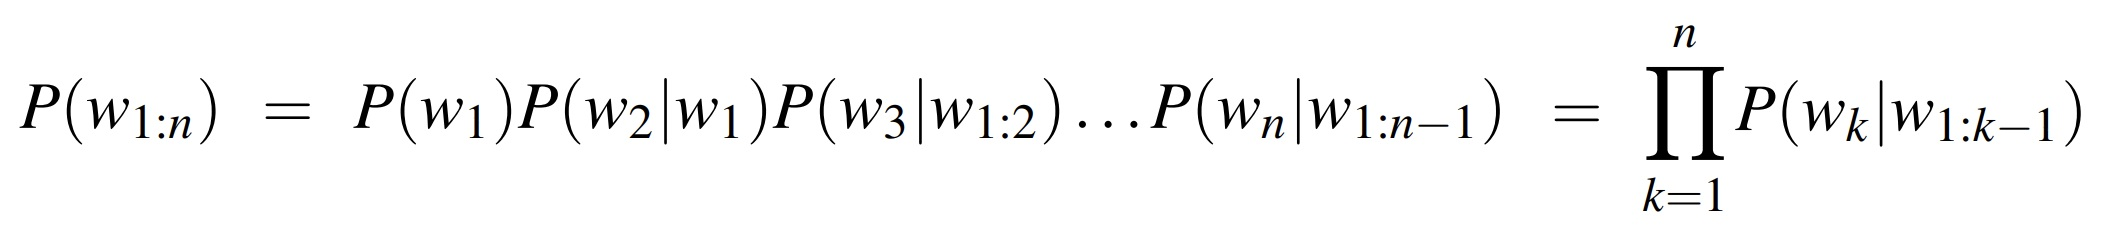

The chain rule shows the link between computing the joint probability of a
sequence and computing the conditional probability of a word given previous words. But using the chain rule doesn't really seem to help us! We don't know any way to compute the exact probability of a word given a long sequence of preceding words.

The intuition of the n-gram model is that instead of computing the probability of a word given its entire history, we can approximate the history by just the last few words.

Let's see a general equation for this n-gram approximation to the conditional
probability of the next word in a sequence. We'll use $N$ here to mean the n-gram size. We approximate the probability of a word given its entire context as follows:

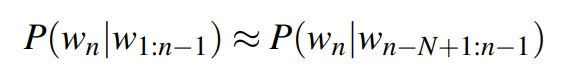

For more details, see e.g. this [source](https://web.stanford.edu/~jurafsky/slp3/3.pdf).

We first need to tokenize the data

In [ ]:
tokenized_data = []
for text in tqdm(train_data, desc='Tokenizing training data'):
    tokens = tokenize_sp(text[1])
    tokenized_data.append(tokens)

In [ ]:
sos_token = '<SOS>'  # start of sentence token. Appending this at the start will make the selection of first token also probabilistic based according to corpus
eos_token = '<EOS>'

Let's build the model

In [ ]:
class NGramLanguageModel():

    def __init__(self, n):

        self.n = n
        self.word_freqs = defaultdict(dict) # 1 to n-1 grams: {dict of possible words: frequency}

    def train(self, sentences):

        for sentence in tqdm(sentences, desc='Processing Sentences'):

            for gram_size in range(2, self.n+1):  # 2 because we need to make key(gram[:-1]) val(gram[-1]) pairs and need at least 2.

                ngrams = build_ngrams([sos_token]+sentence+[eos_token], gram_size)  # need to manually append eos_token at the end of sentences

                for ngram in ngrams:

                    pass  # TO-DO: fill in self.word_freqs dictionary

    def generate_sentence(self, starting_state=None, max_length=50):

        generated_sentence = []

        if starting_state is None:
            generated_sentence = [sos_token]
        elif isinstance(starting_state, str):
            generated_sentence = starting_state.split()

        if generated_sentence[0] != sos_token:
            generated_sentence = [sos_token]+generated_sentence

        max_key_len = self.n-1

        if tuple(generated_sentence[-1:]) not in self.word_freqs:  # python automatically takes care of the case if the max_key_len is bigger than total list size
            raise ValueError('Invalid starting state')

        while len(generated_sentence) <= max_length:

            # TO-DO: add next word to generated_sentence based on frequencies computed above
            next_word = None
            generated_sentence.append(next_word)

            if next_word == eos_token:
                break

        return generated_sentence


In [ ]:
model = NGramLanguageModel(n=5)  # The bigger the value of n, the better (but bigger) the model.

In [ ]:
model.train(tokenized_data)

Let's see the results:

In [ ]:
# 5 completely random sentences
for _ in range(5):
    sentence_tokens = model.generate_sentence()
    print(' '.join(sentence_tokens))  # skip SOS and EOS tokens
    print('-'*20)

In [ ]:
model.generate_sentence(starting_state='I felt like')